**Model Usulan Paper**

GRU - LSTM

=========================

**Struktur Model**

=========================

LSTM 1(Unit=20, Dropout=0.2, Activation=tanh)

    |

LSTM 2(Unit=50, Dropout=0.2, Activation=tanh)

    |

GRU 1(Unit=30, Dropout=0.2, Activation=tanh)

    |

GRU 2(Unit=10, Dropout=0.2, Activation=tanh)

    |

Dense (1)

    |

Sigmoid

=========================

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvFeatureExtractor(nn.Module):
    def __init__(self):
        super(ConvFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(0.2)

    def forward(self, x):  # x shape: (B, 3, 224, 224)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)

        x = x.view(x.size(0), -1)
        return x

In [ ]:
import torch
import torch.nn as nn

class HybridLSTMGRU(nn.Module):
    def __init__(self, input_size):
        super(HybridLSTMGRU, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=20, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)

        self.lstm2 = nn.LSTM(input_size=20, hidden_size=50, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)

        self.gru1 = nn.GRU(input_size=50, hidden_size=30, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)

        self.gru2 = nn.GRU(input_size=30, hidden_size=10, batch_first=True)
        self.dropout4 = nn.Dropout(0.2)

        self.fc = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)

        x, _ = self.lstm2(x)
        x = self.dropout2(x)

        x, _ = self.gru1(x)
        x = self.dropout3(x)

        x, _ = self.gru2(x)
        x = self.dropout4(x)

        x = x[:, -1, :]
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [ ]:
class DeepfakeHybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = ConvFeatureExtractor()
        self.rnn = HybridLSTMGRU(input_size=512)
        self.project = nn.Linear(62720, 512)

    def forward(self, x):  # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        feats = self.cnn(x)            # (B*T, D)
        feats = self.project(feats)
        feats = feats.view(B, T, -1)   # (B, T, D)
        x = self.rnn(feats)            # (B, 1)
        return x

**Load Dataset**

In [ ]:
from torch.utils.data import Dataset
import torch
import os

class FeatureSequenceDataset(Dataset):
    def __init__(self, folder):
        self.files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.pt')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(self.files[idx])
        x = torch.stack(data['frames'])
        y = torch.tensor(data['label']).float()
        return x, y

In [ ]:
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch

# Dataset
folder_path = 'Dataset Deepfake Preprocessed/Preprocessed Wajah'
dataset = FeatureSequenceDataset(folder_path)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=1, shuffle=True, collate_fn=lambda x: (
    torch.stack([i[0] for i in x]), torch.tensor([i[1] for i in x])))
val_loader = DataLoader(val_data, batch_size=1, shuffle=False, collate_fn=lambda x: (
    torch.stack([i[0] for i in x]), torch.tensor([i[1] for i in x])))

**Load Setting Model**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeHybridModel().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Uji Coba Training**

In [ ]:
num_epochs = 40
best_val_loss = float('inf')
best_val_acc = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for frames, labels in train_loader:
        frames = frames.to(device)
        labels = labels.to(device).float()  # float untuk BCELoss

        optimizer.zero_grad()
        outputs = model(frames).squeeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        predicted = (outputs > 0.5).float()
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = frames.to(device)
            labels = labels.to(device).float()

            outputs = model(frames).squeeze(1)
            labels = labels.float()
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Save model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/Paper-3/LSTM-GRU.pth')

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

C:\Users\krist\AppData\Local\Temp\ipykernel_483208\1074632865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(data['label']).float()  # scalar


Epoch [1/40] Train Loss: 2.8545 | Train Acc: 0.4963 | Val Loss: 2.1675 | Val Acc: 0.5970
Epoch [2/40] Train Loss: 2.8557 | Train Acc: 0.4739 | Val Loss: 2.1675 | Val Acc: 0.5970
Epoch [3/40] Train Loss: 2.8574 | Train Acc: 0.4813 | Val Loss: 2.1675 | Val Acc: 0.5970
Epoch [4/40] Train Loss: 2.8553 | Train Acc: 0.4813 | Val Loss: 2.1675 | Val Acc: 0.5970
Epoch [5/40] Train Loss: 2.8556 | Train Acc: 0.4851 | Val Loss: 2.1675 | Val Acc: 0.5970
Epoch [6/40] Train Loss: 2.8546 | Train Acc: 0.4851 | Val Loss: 2.1675 | Val Acc: 0.5970
Epoch [7/40] Train Loss: 2.8550 | Train Acc: 0.4851 | Val Loss: 2.1675 | Val Acc: 0.5970
Epoch [8/40] Train Loss: 2.8555 | Train Acc: 0.4851 | Val Loss: 2.1675 | Val Acc: 0.5970
Epoch [9/40] Train Loss: 2.8562 | Train Acc: 0.4851 | Val Loss: 2.1675 | Val Acc: 0.5970
Epoch [10/40] Train Loss: 2.8576 | Train Acc: 0.4888 | Val Loss: 2.1675 | Val Acc: 0.5970
Epoch [11/40] Train Loss: 2.8559 | Train Acc: 0.4851 | Val Loss: 2.1675 | Val Acc: 0.5970
Epoch [12/40] Train

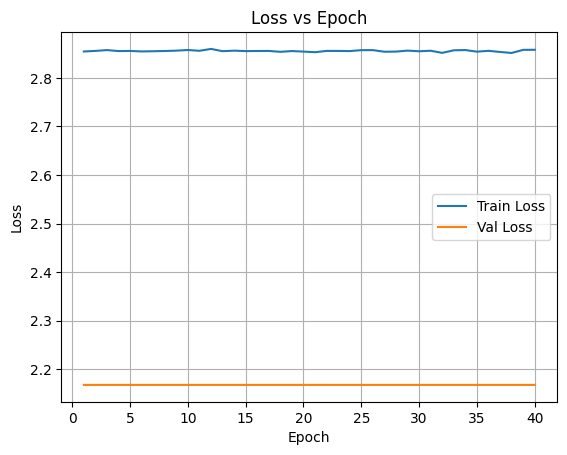

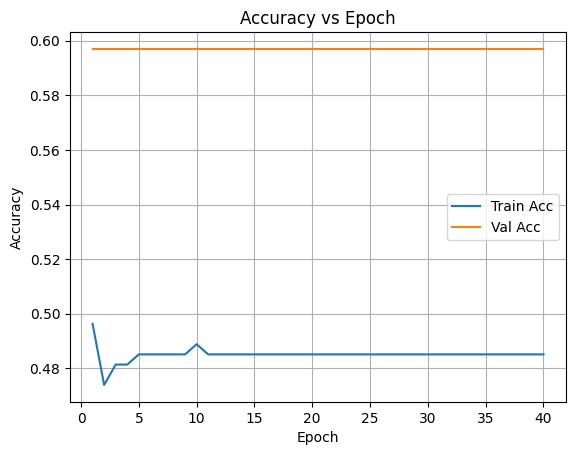

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

**Uji Coba Testing**

aabyjxwqyo.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = REAL, True = REAL
aqhbszcpal.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = REAL, True = REAL
bfkzrgovsv.pt: Predicted = REAL, True = REAL
bfljjbavig.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = REAL, True = REAL
bqwwkjlmgv.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
chjatzdqcl.pt: Predicted = REAL, True = REAL
chnbexdyhq.pt: Predicted = REAL, True = REAL
cmbloezomc.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
cuewtjauyi.pt: Predict

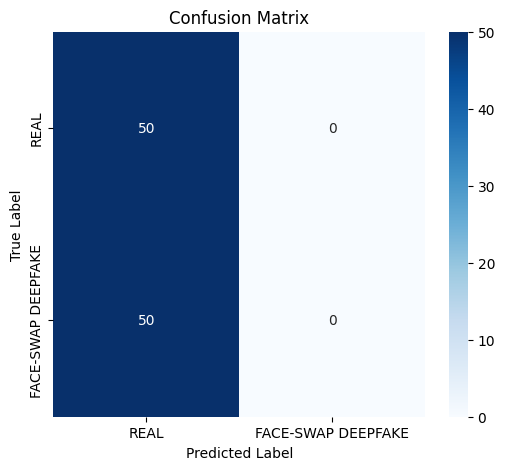


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.50      1.00      0.67        50
FACE-SWAP DEEPFAKE       0.00      0.00      0.00        50

          accuracy                           0.50       100
         macro avg       0.25      0.50      0.33       100
      weighted avg       0.25      0.50      0.33       100


📈 AUC Score: 0.4618


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

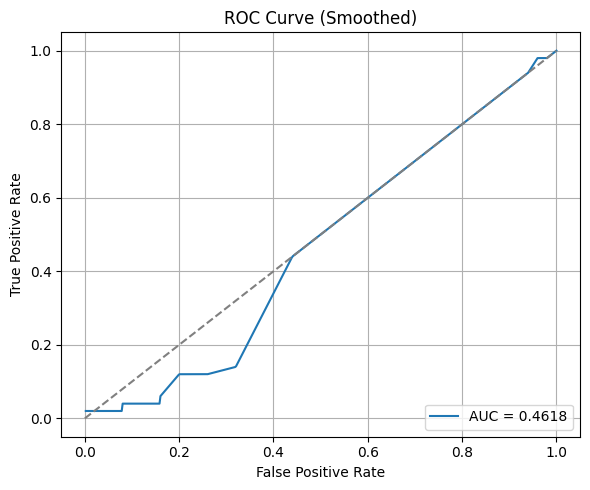

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = DeepfakeHybridModel()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/Paper-3/LSTM-GRU.pth"
pt_folder = "Dataset Deepfake Preprocessed/Preprocessed Wajah/testing/testing 1080p"
model = load_model(model_path)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)  # (1, T, 3, 224, 224)


    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probability = outputs.item()
        predicted = int(probability > 0.5)
        probs_class1.append(probability)

    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
total = len(true_labels)
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, probs_class1)

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")

Coba Learning rate 1e-5

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeHybridModel().to(device)
criterion = nn.BCELoss()
# Ganti learning rate menjadi 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
num_epochs = 40
best_val_loss = float('inf')
best_val_acc = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for frames, labels in train_loader:
        frames = frames.to(device)
        labels = labels.to(device).float()  # float untuk BCELoss

        optimizer.zero_grad()
        outputs = model(frames).squeeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        predicted = (outputs > 0.5).float()
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = frames.to(device)
            labels = labels.to(device).float()

            outputs = model(frames).squeeze(1)
            labels = labels.float()
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Save model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/Paper-3/LSTM-GRU_LR1e-5.pth')

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

C:\Users\krist\AppData\Local\Temp\ipykernel_461592\1074632865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(data['label']).float()  # scalar


Epoch [1/40] Train Loss: 2.7355 | Train Acc: 0.5075 | Val Loss: 2.6642 | Val Acc: 0.5075
Epoch [2/40] Train Loss: 2.7329 | Train Acc: 0.5075 | Val Loss: 2.6643 | Val Acc: 0.5075
Epoch [3/40] Train Loss: 2.7303 | Train Acc: 0.5075 | Val Loss: 2.6642 | Val Acc: 0.5075
Epoch [4/40] Train Loss: 2.7330 | Train Acc: 0.5075 | Val Loss: 2.6642 | Val Acc: 0.5075
Epoch [5/40] Train Loss: 2.7315 | Train Acc: 0.5075 | Val Loss: 2.6642 | Val Acc: 0.5075
Epoch [6/40] Train Loss: 2.7329 | Train Acc: 0.5075 | Val Loss: 2.6642 | Val Acc: 0.5075
Epoch [7/40] Train Loss: 2.7325 | Train Acc: 0.5075 | Val Loss: 2.6643 | Val Acc: 0.5075
Epoch [8/40] Train Loss: 2.7342 | Train Acc: 0.5075 | Val Loss: 2.6643 | Val Acc: 0.5075
Epoch [9/40] Train Loss: 2.7314 | Train Acc: 0.5075 | Val Loss: 2.6643 | Val Acc: 0.5075
Epoch [10/40] Train Loss: 2.7340 | Train Acc: 0.5075 | Val Loss: 2.6643 | Val Acc: 0.5075
Epoch [11/40] Train Loss: 2.7277 | Train Acc: 0.5075 | Val Loss: 2.6644 | Val Acc: 0.5075
Epoch [12/40] Train

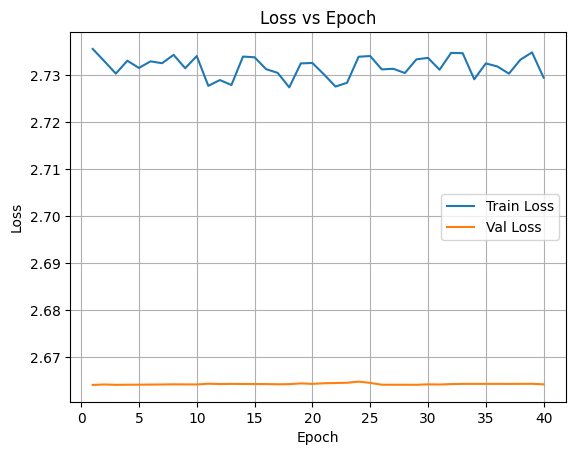

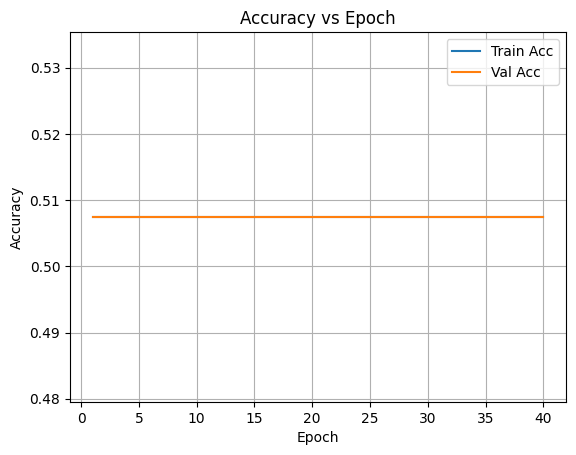

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

aabyjxwqyo.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = REAL, True = REAL
aqhbszcpal.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = REAL, True = REAL
bfkzrgovsv.pt: Predicted = REAL, True = REAL
bfljjbavig.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = REAL, True = REAL
bqwwkjlmgv.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
chjatzdqcl.pt: Predicted = REAL, True = REAL
chnbexdyhq.pt: Predicted = REAL, True = REAL
cmbloezomc.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
cuewtjauyi.pt: Predict

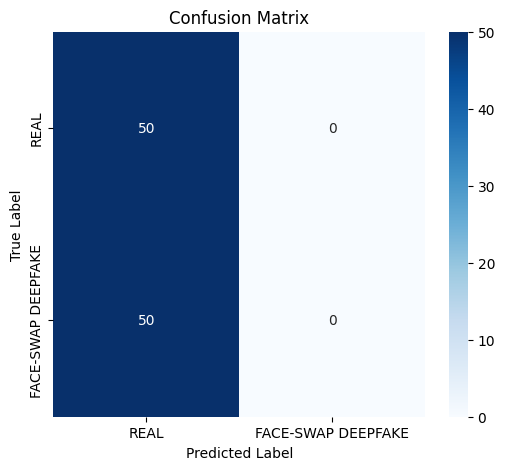


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.50      1.00      0.67        50
FACE-SWAP DEEPFAKE       0.00      0.00      0.00        50

          accuracy                           0.50       100
         macro avg       0.25      0.50      0.33       100
      weighted avg       0.25      0.50      0.33       100


📈 AUC Score: 0.4876


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

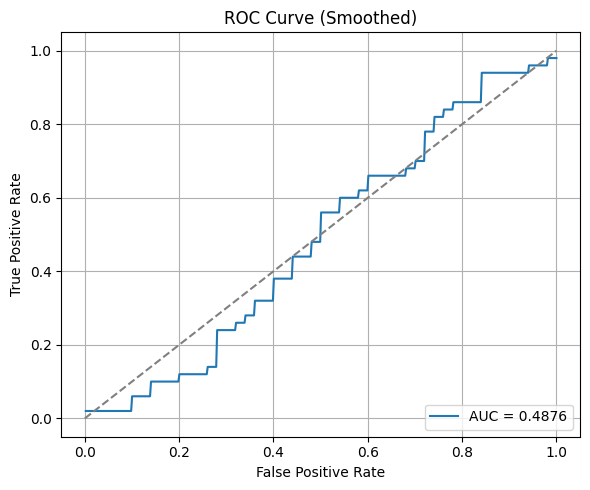

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = DeepfakeHybridModel()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/Paper-3/LSTM-GRU_LR1e-5.pth"
pt_folder = "Dataset Deepfake Preprocessed/Preprocessed Wajah/testing/testing 1080p"
model = load_model(model_path)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)  # (1, T, 3, 224, 224)


    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probability = outputs.item()  # scalar output from sigmoid
        predicted = int(probability > 0.5)
        probs_class1.append(probability)

    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
total = len(true_labels)
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, probs_class1)

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")

Coba Learning rate 1e-3

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeHybridModel().to(device)
criterion = nn.BCELoss()
# Ganti learning rate menjadi 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 40
best_val_loss = float('inf')
best_val_acc = float('inf')

# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for frames, labels in train_loader:
        frames = frames.to(device)
        labels = labels.to(device).float()  # float untuk BCELoss

        optimizer.zero_grad()
        outputs = model(frames).squeeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        predicted = (outputs > 0.5).float()
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = frames.to(device)
            labels = labels.to(device).float()

            outputs = model(frames).squeeze(1)
            labels = labels.float()
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Save model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/Paper-3/LSTM-GRU_LR1e-3.pth')

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

C:\Users\krist\AppData\Local\Temp\ipykernel_461592\1074632865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(data['label']).float()  # scalar


Epoch [1/40] Train Loss: 2.7259 | Train Acc: 0.5261 | Val Loss: 2.6641 | Val Acc: 0.5075
Epoch [2/40] Train Loss: 2.7363 | Train Acc: 0.4963 | Val Loss: 2.6641 | Val Acc: 0.5075
Epoch [3/40] Train Loss: 2.7314 | Train Acc: 0.5075 | Val Loss: 2.6641 | Val Acc: 0.5075
Epoch [4/40] Train Loss: 2.7326 | Train Acc: 0.4813 | Val Loss: 2.6641 | Val Acc: 0.5075
Epoch [5/40] Train Loss: 2.7407 | Train Acc: 0.4291 | Val Loss: 2.6641 | Val Acc: 0.5075
Epoch [6/40] Train Loss: 2.7327 | Train Acc: 0.5261 | Val Loss: 2.6641 | Val Acc: 0.5075
Epoch [7/40] Train Loss: 2.7369 | Train Acc: 0.4701 | Val Loss: 2.6641 | Val Acc: 0.5075
Epoch [8/40] Train Loss: 2.7304 | Train Acc: 0.5000 | Val Loss: 2.6641 | Val Acc: 0.5075
Epoch [9/40] Train Loss: 2.7381 | Train Acc: 0.4590 | Val Loss: 2.6641 | Val Acc: 0.5075
Epoch [10/40] Train Loss: 2.7311 | Train Acc: 0.5037 | Val Loss: 2.6641 | Val Acc: 0.5075
Epoch [11/40] Train Loss: 2.7325 | Train Acc: 0.5000 | Val Loss: 2.6641 | Val Acc: 0.5075
Epoch [12/40] Train

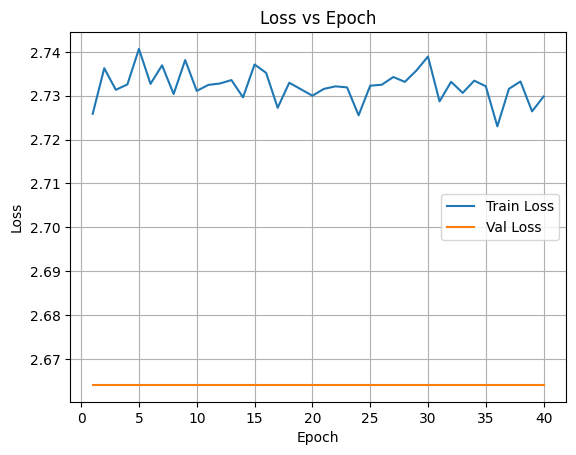

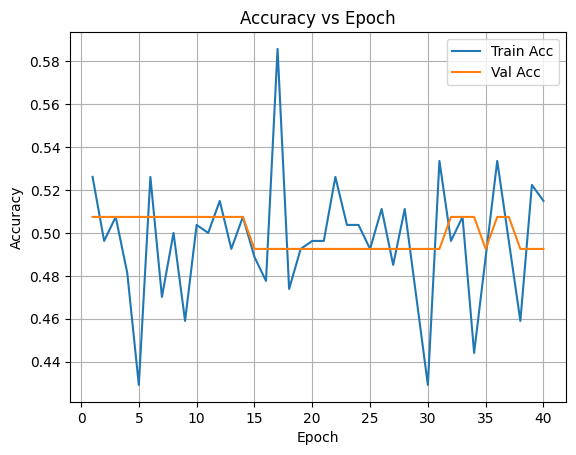

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

aabyjxwqyo.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
aqhbszcpal.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfkzrgovsv.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfljjbavig.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bqwwkjlmgv.pt: Predicted = FACE-SW

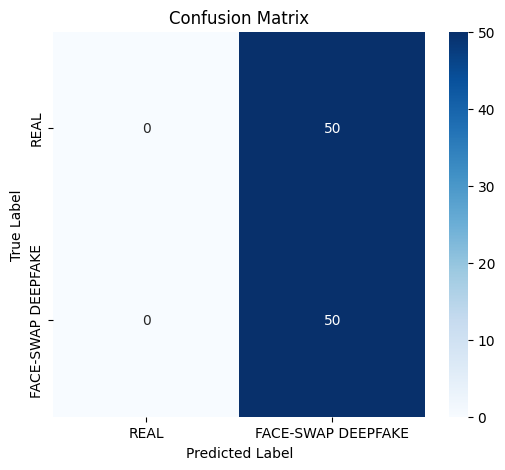


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.00      0.00      0.00        50
FACE-SWAP DEEPFAKE       0.50      1.00      0.67        50

          accuracy                           0.50       100
         macro avg       0.25      0.50      0.33       100
      weighted avg       0.25      0.50      0.33       100


📈 AUC Score: 0.5000


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

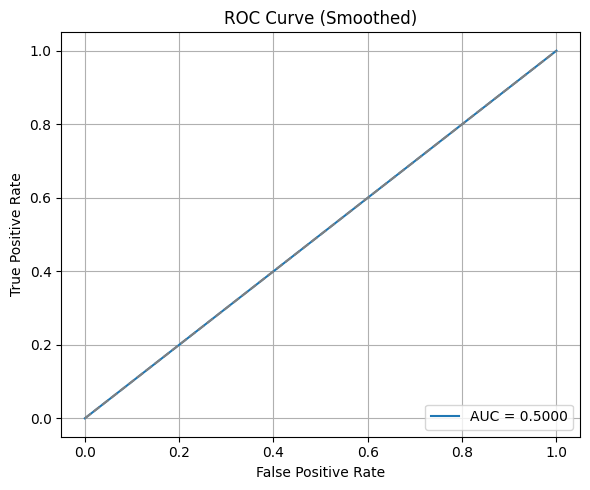

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = DeepfakeHybridModel()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/Paper-3/LSTM-GRU_LR1e-3.pth"
pt_folder = "Dataset Deepfake Preprocessed/Preprocessed Wajah/testing/testing 1080p"
model = load_model(model_path)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)  # (1, T, 3, 224, 224)


    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)  # (1, 1)
        probability = outputs.item()  # scalar output from sigmoid
        predicted = int(probability > 0.5)
        probs_class1.append(probability)

    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
total = len(true_labels)
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, probs_class1)

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")